In [24]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from pathlib import Path
import xml.etree.ElementTree as ET

### Quelle der Daten: 
https://www.bundestag.de/services/opendata

### Erläuterungen
WP steht für Wahlperiode

In [2]:
DATA_PATH = Path('data')
MDB_XML_PATH = DATA_PATH / 'MDB_STAMMDATEN.XML'
DF_MDB_PATH = DATA_PATH / 'df_mdb.csv' #one row per individuum, one col per wp containing 0 / 1
DF_MDB_WP_PATH = DATA_PATH / 'df_mdb_wp.csv' # one row per individuum per wp, containting e.g. 12. so one abgeordneter who has been in parliament for several wp will receive one row per wp

# parse xml data into dataFrame / .csv fomat

In [3]:
def get_mdb_data(mdb_xml_path = MDB_XML_PATH):
    """get data frame of MDP data
    ID | NACHNAME | VORNAME |  ... | BERUF"""
    list_of_mdb = []
    MDB_STAMMDATEN = ET.parse(mdb_xml_path)
    root = MDB_STAMMDATEN.getroot()
    
    for mdb in root.findall('MDB'):
        mdb_dict = {}
        ID, NAMEN, BIOGRAFISCHE_ANGABEN, WAHLPERIODEN = mdb[0], mdb[1], mdb[2], mdb[3]

        mdb_dict['ID'] = ID.text
        mdb_dict['NACHNAME'] = NAMEN.find('NAME').find('NACHNAME').text  
        mdb_dict['VORNAME'] = NAMEN.find('NAME').find('VORNAME').text  

        #print(mdb.tag, mdb.text, mdb.findall('NACHNAME'))
        for element in BIOGRAFISCHE_ANGABEN:
            mdb_dict[element.tag] = element.text

        mdb_dict['ANZ_WAHLPERIODEN'] = len(list(WAHLPERIODEN))

        for wahlperiode in WAHLPERIODEN:
            mdb_dict[int(wahlperiode.find('WP').text)] = 1

        list_of_mdb.append(mdb_dict)
    return pd.DataFrame(list_of_mdb)

In [4]:
def get_mdb_wp_data(df_mdb):
    """
    reformat
    peter | lustig | wp1 | wp2
    
    into
    peter | lustig | wp1
    peter | lustig | wp2
    """
    
    wps = [column for column in df_mdb.columns if isinstance(column, int)] # probably 1 to 19 or 20
    columns_to_keep = [column for column in df_mdb.columns if not isinstance(column, int)] # 'BERUF', 'VITA_KURZ' etc
    
    # should be 19 before 2021, 20 afterwards
    max_wp = max(wps)
    
    # this could be optimized but only runs once for about 2 Minutes
    new_entries = []
    for idx, row in df_mdb.iterrows():
        for wp in wps:
            if row[wp] == 1:
                new_entry = row[columns_to_keep]
                new_entry['WP'] = wp
                new_entries.append(new_entry)
    
    mdb_wp = pd.DataFrame(new_entries)
    return(mdb_wp)

In [5]:
df_mdb = get_mdb_data(MDB_XML_PATH)
print(df_mdb.shape)
df_mdb.head()

(4089, 34)


,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,...,2,12,13,14,15,16,1,17,18,19
0,11000001,Abelein,Manfred,20.10.1930,Stuttgart,None,17.01.2008,männlich,keine Angaben,katholisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11000002,Achenbach,Ernst,09.04.1909,Siegen,None,02.12.1991,männlich,"verheiratet, 3 Kinder",evangelisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11000003,Ackermann,Annemarie,26.05.1913,Parabutsch,Jugoslawien,18.02.1994,weiblich,"verheiratet, 5 Kinder",katholisch,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11000004,Ackermann,Else,06.11.1933,Berlin,None,14.09.2019,weiblich,ledig,evangelisch,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11000005,Adam,Ulrich,09.06.1950,"Teterow, Kr. Teterow, Bezirk Neubrandenburg",None,None,männlich,"verheiratet, 2 Kinder",evangelisch,...,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN


In [6]:
df_mdb_wp = get_mdb_wp_data(df_mdb)

## Insight: es werden immer mehr Abgeordnete

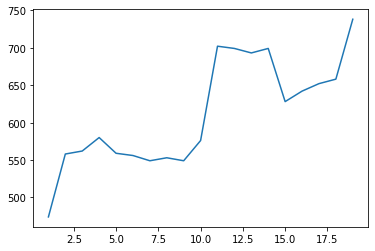

In [7]:
wps = [column for column in df_mdb.columns if isinstance(column, int)]
fig, ax = plt.subplots()#plt.figure(figsize=(8,6))

# xlab / ylab not showing is nb issue
plt.xlabel='WP'
plt.ylabel='Anzahl Abgeordneter'
#plt.plot(df_mdb[wps].sum().sort_index())
df_mdb[wps].sum().sort_index().plot()
plt.show()

In [8]:
df_mdb[wps].sum().sort_index().tail()

15    628.0
16    642.0
17    652.0
18    658.0
19    738.0
dtype: float64

In [9]:
# total number of abgeordnete (counting multiple wps as multiple entries)
df_mdb[wps].sum().sum()

11627.0

In [10]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(df_mdb_wp[df_mdb_wp.NACHNAME =='Baerbock'].iloc[0].VITA_KURZ)

('2000/04 Studium der Politikwissenschaft und Öffentliches Recht in Hamburg; '
 '2000/03 freie Mitarbeit bei der Hannoverschen Allgemeinen Zeitung; 2005 '
 'Master im Völkerrecht (LL.M.) an der LSE London; 2005/08 Büroleiterin der '
 'Europaabgeordneten Elisabeth Schroedter in Brüssel und Potsdam. 2008/09 '
 'Referentin für Außen- und Sicherheitspolitik bei der Grünen '
 'Bundestagsfraktion. 2009/13 Landesvors. BÜNDNIS 90/DIE GRÜNEN Brandenburg. '
 'Seit 2005 Mitgl. von Bündnis 90/Die Grünen, 2009/12 Mitgl. im Vorstand der '
 'Europäischen Grünen Partei; 2012/15 Mitgl. im Parteirat von Bündnis 90/Die '
 'Grünen, seit Jan. 2018 Bundesvors. von Bündnis90/Die Grünen. Englisch (f), '
 'Französisch (G), Spanisch (G). - MdB seit Okt. 2013.')


# clean data 1. missing values

In [11]:
dimensions_replace_na = ['NACHNAME', 'VORNAME', 'GEBURTSDATUM', 'GEBURTSORT', 'GEBURTSLAND', 'STERBEDATUM', 'GESCHLECHT', 'FAMILIENSTAND', 'RELIGION', 'BERUF', 'PARTEI_KURZ']
df_mdb[dimensions_replace_na].isna().sum()

NACHNAME            0
VORNAME             0
GEBURTSDATUM        0
GEBURTSORT          4
GEBURTSLAND      4010
STERBEDATUM      2199
GESCHLECHT          0
FAMILIENSTAND      81
RELIGION          227
BERUF               3
PARTEI_KURZ         3
dtype: int64

In [12]:
df_mdb[dimensions_replace_na] = df_mdb[dimensions_replace_na].fillna('UNBEKANNT')

# 2. replace values: PARTEI_KURZ

In [13]:
df_mdb.PARTEI_KURZ.value_counts()[:12]

CDU                      1347
SPD                      1329
FDP                       460
CSU                       269
BÜNDNIS 90/DIE GRÜNEN     180
DIE LINKE.                128
AfD                        88
PDS                        54
GRÜNE                      51
DIE GRÜNEN/BÜNDNIS 90      28
DP                         27
FU                         21
Name: PARTEI_KURZ, dtype: int64

In [14]:
# some cleaning necessary: 'BÜNDNIS 90/DIE GRÜNEN', 'DIE GRÜNEN/BÜNDNIS 90' => 'GRÜNE'
for grünen_alias in ['BÜNDNIS 90/DIE GRÜNEN', 'DIE GRÜNEN/BÜNDNIS 90', 'GRÜNE']:
    df_mdb.replace(grünen_alias, 'DIE GRÜNEN', inplace=True)

# replace values: RELIGION

In [15]:
df_mdb['RELIGION_MAPPED'] = df_mdb['RELIGION']
df_mdb.RELIGION_MAPPED.value_counts().head(12)

ohne Angaben              1214
evangelisch               1154
katholisch                 870
römisch-katholisch         316
UNBEKANNT                  227
evangelisch-lutherisch     138
konfessionslos             118
evangelisch-reformiert      15
religionslos                 7
Atheistin                    6
muslimisch                   5
Islam                        3
Name: RELIGION_MAPPED, dtype: int64

In [16]:
for katholisch_alias in ['römisch-katholisch', 'alt-katholisch']:
    df_mdb['RELIGION_MAPPED'].replace(katholisch_alias, 'katholisch', inplace=True)

In [17]:
for evangelisch_alias in ['evangelisch-lutherisch', 'evangelisch-reformiert', 'evangelisch-freikirchlich', 'protestantisch']:
    df_mdb['RELIGION_MAPPED'].replace(evangelisch_alias, 'evangelisch', inplace=True)

In [18]:
# it's not the same but its similar
for konfessionslos_alias in ['religionslos', 'Atheist', 'Atheistin']:
    df_mdb['RELIGION_MAPPED'].replace(konfessionslos_alias, 'konfessionslos', inplace=True)

In [19]:
for konfessionslos_alias in ['Islam']:
    df_mdb['RELIGION_MAPPED'].replace(konfessionslos_alias, 'muslimisch', inplace=True)

In [20]:
# erkenntnis: nur christen und einige wenige konfessionslose
df_mdb['RELIGION_MAPPED'].value_counts().head(24)

evangelisch            1311
ohne Angaben           1214
katholisch             1187
UNBEKANNT               227
konfessionslos          133
muslimisch                8
freireligiös              3
humanistisch              1
neuapostolisch            1
orthodox                  1
alevitisch                1
griechisch-orthodox       1
russisch-orthodox         1
Name: RELIGION_MAPPED, dtype: int64

<AxesSubplot:>

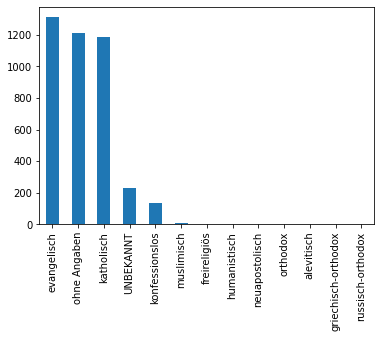

In [21]:
df_mdb['RELIGION_MAPPED'].value_counts().plot(kind='bar')

# replace values: FAMILIENSTAND

In [22]:
# gehen sie weiter. hier gibt es kein Klischee zu erkennen!
df_mdb['FAMILIENSTAND_MAPPED'] = df_mdb['FAMILIENSTAND']
df_mdb.FAMILIENSTAND_MAPPED= df_mdb.FAMILIENSTAND_MAPPED.apply(lambda x: x.replace('verheiratet', 'verh.'))
df_mdb.FAMILIENSTAND_MAPPED= df_mdb.FAMILIENSTAND_MAPPED.apply(lambda x: x.replace('geschieden', 'gesch.'))
df_mdb[['ID', 'FAMILIENSTAND_MAPPED']].groupby('FAMILIENSTAND_MAPPED').count().sort_values(by='ID', ascending=False).head(16)

,ID
FAMILIENSTAND_MAPPED,
"verh., 2 Kinder",932
verh.,565
"verh., 3 Kinder",550
keine Angaben,540
"verh., 1 Kind",465
"verh., 4 Kinder",251
ledig,202
"verh., 5 Kinder",98
UNBEKANNT,81


In [25]:
indikator = re.compile('^verh.,\s([4-9] |\d{2,}) *Kind')
values_to_replace = set(df_mdb[df_mdb.FAMILIENSTAND_MAPPED.str.contains(indikator)].FAMILIENSTAND_MAPPED)
print(values_to_replace)
replace_value = 'verh., >3 Kinder'
df_mdb['FAMILIENSTAND_MAPPED'].replace(values_to_replace, replace_value, inplace=True)

{'verh., 12 Kinder', 'verh., 4 Kinder', 'verh., 6 Kinder', 'verh., 10 Kinder', 'verh., 7 Kinder', 'verh., 9 Kinder', 'verh., 5 Kinder', 'verh., 8 Kinder'}


/usr/local/lib/python3.9/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [26]:
indikator = re.compile('^gesch.,\s([1-9] |\d{2,}) *Kind')
values_to_replace = set(df_mdb[df_mdb.FAMILIENSTAND_MAPPED.str.contains(indikator)].FAMILIENSTAND_MAPPED)
print(values_to_replace)
replace_value = 'gesch., >0 Kinder'
df_mdb['FAMILIENSTAND_MAPPED'].replace(values_to_replace, replace_value, inplace=True)

{'gesch., 5 Kinder', 'gesch., 1 Kind', 'gesch., 2 Kinder', 'gesch., 4 Kinder', 'gesch., 3 Kinder'}


In [27]:
df_mdb[['ID', 'FAMILIENSTAND_MAPPED']].groupby('FAMILIENSTAND_MAPPED').count().sort_values(by='ID', ascending=False).head(16)

,ID
FAMILIENSTAND_MAPPED,
"verh., 2 Kinder",932
verh.,565
"verh., 3 Kinder",550
keine Angaben,540
"verh., 1 Kind",465
"verh., >3 Kinder",422
ledig,202
UNBEKANNT,81
"gesch., >0 Kinder",80


# replace values: BERUFE

In [28]:
# number of different jobs: 2k
len(set(df_mdb.BERUF))

2201

In [29]:
df_mdb['BERUF_MAPPED'] = df_mdb['BERUF'].copy()

In [30]:
df_mdb[['ID', 'BERUF']].groupby('BERUF').count().sort_values(by='ID', ascending=False).head(8)

,ID
BERUF,
Rechtsanwalt,182
Geschäftsführer,80
Landwirt,79
Angestellter,63
Rechtsanwalt und Notar,47
Kaufmann,45
Journalist,43
Hausfrau,41


In [31]:
from importlib import reload
import berufe_mapping 
reload(berufe_mapping)
from berufe_mapping import basic_cleaning_berufe

'''very basic cleaning: lowercasing, removing dipl., (fh) and a.d.'''
df_mdb = basic_cleaning_berufe(df_mdb , column = 'BERUF_MAPPED')

In [32]:
df_mdb[['ID', 'BERUF_MAPPED']].groupby('BERUF_MAPPED').count().sort_values(by='ID', ascending=False).head(8)

,ID
BERUF_MAPPED,
rechtsanwalt,373
geschäftsführer,111
landwirt,105
-ingenieur,101
-volkswirt,82
lehrer,75
jurist,73
angestellter,73


In [33]:
re.sub('regierungs(vize)*präs', 'XX', 'abc regierungspräsident xjsk regierungsvizepräsidentin')

'abc XXident xjsk XXidentin'

In [34]:
dict_berufe={}
dict_berufe['Jurist*in'] = ['anwalt', 'jurist', 'richter', 'notar', re.compile('dr.*\s*jur.*'), 'syndikus', 'rechtsberater']
dict_berufe['Land-/Forstwirt*in'] = ['landwirt', '^[a-z]bauer\s', 'bauer', re.compile('agrar+'), 'forst']
dict_berufe['Unterehmer*in'] = ['unternehmer'] # geschäftsführer geht leider nicht wegen z.B. Parl. Geschäftssführer
dict_berufe['Ingenieur*in'] = ['ingenieur', 'maschinenbau', 'architekt']
dict_berufe['Journalist*in'] = ['journalist', 'redakteur', 'publizist', 'schriftsteller']
dict_berufe['Verleger*in'] = ['verleger', 'verlags']

# direktor: nö, sonst bezirksdirektor museumsdirektor etc
dict_berufe['Lehrer*in'] = ['erzieher', 'pädagog', 'lehrer', 'studienrat', 'studiendirektor', 'schulrat',
                            'grundschul', 'hauptshul', 'sonderschul', 'waldorf', 'realschul', 'gymnasi',
                            'volkshochschu', 'berufsschul', 'fremdsprachen',
                           'schul'] #evtl trennen Erzieher - Lehrer
dict_berufe['Professor*in'] = ['dozent', 'professor', 'prof.', 'hochschull', 'hochschulpr']
dict_berufe['Kaufmann/-frau'] = ['kaufm']
dict_berufe['Volkswirt*in'] = ['volkswirt']
dict_berufe['Berufspolitiker*in'] = ['regierungsangestellt', 'stadtamtmann', 'stadtoberinspektor', 'Landesgeschäftsführer',
                                    'landr(at|ätin)', re.compile('ministerialr(a|ä)t'), 'staatssekret', 'bürgermeist', 
                                     'regierungsrat', re.compile('regierungs(vize)*präs'), 'regierung',
                                     'stadtdirektor', 'ministerialdirektor', 'regierungsdirektor', 'gemeindedirektor', 'regierungsdirektor',
                                     'minister', 'bundeskanz', 'bundestagsp', re.compile('präsident(in)* d\.*b\.*t\.*')]
dict_berufe['Arzt/Ärztin'] = ['arzt', 'psycholog', 'psychother', 'apotheker']
dict_berufe['Theolog*in'] = ['pfarrer', 'theolog', 'diakon']
dict_berufe['Betriebswirt*in'] = ['betriebswirt', 'verwaltungs', 'steuerberater', 'bankdirektor']
dict_berufe['Wirtschaftswissenschaftler*in'] = ['wirtschaftsw', 'ökonom', 'prokurist']
dict_berufe['Geisteswissenschaftler*in'] = ['politolog', 'politikwiss', 'historik', 'philosoph', 'philolog', 'soziolog', 'sozialwissensch', 'kulturwissenschaft']
dict_berufe['Naturwissenschaftler*in'] = ['chemik', 'chemie', 'physik', 'geophysik', 'biolog', 'mathemat', 'informat']

dict_berufe['Handwerker*in'] = ['elektro', 'fahrzeug', 'handwerk', 'mechanik',
                               'schlosser', 'maurer', 'beton', 'maler', 'lackier', 'tischler', 'schreiner',
                               'bäcker', 'konditor' 'koch', 'köchin', 'müller', 'bergmann', 'werkzeugmacher']
dict_berufe['Militär'] = ['leutnant', 'oberst^u', 'soldat', re.compile('general\s')] # not oberstudienrat ;)
dict_berufe['Beamter'] = ['beamter']# problematisch: Berufspolitiker, Lehrer, Militär sind auch beamte

In [35]:
re.sub('oberst[^u]', 'X', 'oberst oberst oberst')

'XXoberst'

In [36]:
def replace_berufsklasse(berufsklasse = 'Jurist*in', dict_berufe = dict_berufe, df = df_mdb):
    values_to_replace = set()
    # TODO without loop but use 'any'
    for indikator in dict_berufe[berufsklasse]:
        values_to_replace = values_to_replace.union(set(df_mdb[df_mdb.BERUF_MAPPED.str.contains(indikator)].BERUF_MAPPED))

    print(values_to_replace)
    df_mdb.replace(list(values_to_replace), berufsklasse, inplace=True)
    return(df_mdb)

In [37]:
df_mdb = replace_berufsklasse(berufsklasse = 'Jurist*in', dict_berufe = dict_berufe, df = df_mdb)

{'rechtsanwalt f. steuerrecht', 'rechtsanwalts-', 'vorsitzender richter am landgericht', 'rechtsanwaltsgehilf', 'handelskammersyndikus', 'syndikusanwalt', 'steuerjurist', 'generalbundesanwalt', 'verwaltungsjurist', 'dr. jur.', 'richter', 'rechtsanwalt u. notar', 'richter am bundesgerichtshof', 'jurist', 'richterin', 'jurist (richter)', 'notar', 'richter am oberverwaltungsgericht', 'wirtschaftsjurist', '-jurist', 'richter am oberlandesgericht', 'richterin am amtsgericht', 'oberstaatsanwalt', 'richterin am landgericht', 'höherer dienst bund/land (ministerialrat); landrat; rechtsanwalt', 'volljurist', 'richter am landgericht', 'oberamtsrichter', 'richterin am kammergericht', 'rechtsanwalt', 'richterin a. lg.', 'richter i. r.', 'syndikus', 'rechtsanwalt (tätigkeit ruhend)', 'handwerkskammersyndikus', 'staatsanwalt', 'rechtanwalt', 'familienrichterin', 'richterin i. r.', 'rechtsberater'}


In [38]:
df_mdb = replace_berufsklasse(berufsklasse = 'Land-/Forstwirt*in', dict_berufe = dict_berufe, df = df_mdb)

{'austragbauer', 'bauer', '-forstingenieur', 'agrarwissenschaftler', 'landwirtschaftsdirektorin', '-forstwirt', 'agraringenieur', 'land- u. forstwirt', 'schiffbauer', 'maschinenbauer', 'forstwirt', 'hochschulagraringenieur', 'oberregierungslandwirtschaftsrat', '-landwirt', '-agraringenieurin', 'landwirtschaftsmeister', 'selbstständiger landwirt', '-agraringenieur', 'straßenbauer', 'landwirtschaftsrat', 'oberlandwirtschaftsrat', 'forstoberrat', 'landwirt', 'betonbauer', 'stahlbetonbauer', 'forstmeister i. r.', 'agrarreferent'}


In [39]:
df_mdb = replace_berufsklasse(berufsklasse = 'Unterehmer*in', dict_berufe = dict_berufe, df = df_mdb)

{'speditionsunternehmer', 'selbst. unternehmer', 'bauunternehmer', 'selbständiger unternehmer', 'handwerksunternehmer', 'selbstständiger unternehmer', 'unternehmer', 'transportunternehmer'}


In [40]:
df_mdb = replace_berufsklasse(berufsklasse = 'Ingenieur*in', dict_berufe = dict_berufe, df = df_mdb)

{'hochschulingenieur', 'ingenieurökonom', 'öffentlich bestellter vermessungsingenieur', 'oberingenieur', '-ingenieur', '-ingenieurökonom', 'wirtschaftsingenieur', 'ingenieur (gr', '-wirtschaftsingenieurin', 'maschinenbaumeister', 'bauingenieur', 'vertriebsingenieur', '-ingenieurin  fb architektur', '-ing.  architekt', 'elektroingenieur', '-innenarchitekt', 'textilingenieur', 'bauingenieur (gr', 'maschinenbauingenieur', 'gartenarchitekt', 'architekt bda', '-maschinenbauingenieur', '-bauingenieur', '-ingenieurin  lebensmittelkonservierer', '-meliorationsingenieur', '-wirtschaftsingenieur', '-chemieingenieur', '-ingenieur (tu)', 'ingenieur', '-ingenieurin', '-elektroingenieur', 'freie innenarchitekt', 'bergingenieur', 'chemieingenieur', 'betriebsingenieur', 'architekt'}


In [41]:
len(set(df_mdb.BERUF_MAPPED))

1001

In [42]:
df_mdb = replace_berufsklasse(berufsklasse = 'Journalist*in', dict_berufe = dict_berufe, df = df_mdb)

{'rundfunk-redakteur', 'freiberufliche redakteur', 'wissenschaftlicher redakteur', 'publizist', 'chefredakteur', 'freier journalist', 'freie journalist', 'redakteur', 'politischer redakteur', 'journalist', 'pr-journalist', 'schriftsteller', 'fernsehjournalist'}


In [43]:
df_mdb = replace_berufsklasse(berufsklasse = 'Lehrer*in', dict_berufe = dict_berufe, df = df_mdb)

{'erzieher', '-sozialpädagog', 'reallehrer', 'sozialpädagog', 'hauptschullehrer', 'oberschulrat i. r.', 'lehrerin', 'lehrer am gymnasium (oberstudienrat)', 'hauptlehrer', 'oberstudienrat', 'schulrätin', '-lehrer biologie/chemie', 'fachschullehrer', 'sonderschullehrerin', 'sozialpädagoge', 'hochschulprofessor', 'pädagogischer leiter', 'regierungs- u.schulrat z. wv.', '-pädagoge', 'volkshochschulangestellter', 'gewerbeschullehrer', 'fachschuldozent', 'realschullehrer', 'schulleiterin', 'studienrat', '-religionspädagoge', '-sportlehrer', '-handelslehrer', 'volkshochschuldirektor', 'sozialpädagoge/sozialarbeiter', 'leitender gesamtschuldirektor', 'lehrerin a. a.', 'schulleiter', 'realschuldirektor', 'schulamtsdirektor', 'fachhochschullehrer', 'hochschullehrer', 'sonderschullehrer', 'gymnastiklehrer', 'berufschullehrer', 'schuldirektor', 'volkshochschulleiter', '-wirtschaftslehrer', 'oberlehrer', 'professor an einer wissenschaftlichen hochschule', 'sttschuldirektor', '-ing. pädagoge', 'lehr

In [44]:
df_mdb = replace_berufsklasse(berufsklasse = 'Kaufmann/-frau', dict_berufe = dict_berufe, df = df_mdb)

{'wirtschaftskaufmann', 'kaufmännischer angestellter', 'einzelhandelskaufmann', 'kaufmännische angestellte', 'kaufmann', 'kaufmännische angest.', 'industriekaufmann', 'reisebürokaufmann', 'reiseverkehrskaufmann', 'kaufmann im einzelhandel', 'großhandelskaufmann', '-kaufmann wp/stb', 'pharmazeutisch kaufmännische assistent', 'selbstständiger kaufmann', 'kaufm.angestellter', '-kaufmann (univ.)', 'versicherungskaufmann', 'versichrungskaufmann', 'mineralölkaufmann', 'viehkaufmann', '-kaufmann', 'bankkaufmann', 'textilkaufmann', 'grundstücks- u. wohnungswirtschaftskaufmann', 'technischer kaufmann', 'kaufmännischer direktor', 'werbekaufmann', 'selbstständige industriekaufmann', 'immobilienkaufmann', 'hotelkaufmann', 'außenhandelskaufmann', 'selbständiger einzelhandelskaufmann', 'speditionskaufmann', 'selbständiger kaufmann', 'bürokaufmann', 'verlagskaufmann', 'selbst. kaufmann', 'schifffahrtskaufmann', 'kaufm. angestellte', 'datenverarbeitungskaufmann', 'baukaufmann'}


In [45]:
df_mdb = replace_berufsklasse(berufsklasse = 'Professor*in', dict_berufe = dict_berufe, df = df_mdb)

{'ordentlicher universitätsprofessor', 'prof.', 'ordentlicher professor', 'professor', 'o. universitätsprofessor', 'professor der betriebswirtschaft', 'studienprofessor', 'o. professor', 'universitätsprofessor', 'universitätsprofessor der rechte', 'dozent', 'honorarprofessor'}


In [46]:
len(set(df_mdb.BERUF_MAPPED))

844

In [47]:
df_mdb = replace_berufsklasse(berufsklasse = 'Volkswirt*in', dict_berufe = dict_berufe, df = df_mdb)

{'volkswirt', '-volkswirt', 'volkswirtschaftler', '-volkswirt (uni)', 'volkswirt (gr', 'technischer -volkswirt', '-volkswirt (universität)'}


In [48]:
df_mdb = replace_berufsklasse(berufsklasse = 'Berufspolitiker*in', dict_berufe = dict_berufe, df = df_mdb)

/usr/local/lib/python3.9/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


{'regierungsangestellte', 'staatsminister im auswärtigen amt', 'staatss. b. minister', 'bürgermeisterin', 'referent (staatsministerium)', 'landrat i. r.', 'bundesminister der justiz', 'staatssekretär im ministerium', '1. bürgermeister', 'regierungsdirektor', 'leitender regierungsdirektor', 'bundesministerin', 'regierungsrät', 'beamter (leitender regierungsdirektor)', 'ministerialdirigent', 'wirtschaftsminister u. stellvertr. ministerpräsident', 'bürgermeister i. r.', 'präsidentin dbt', 'vizepräsident dbt', 'erster bürgermeister', 'ministerrialreferent', 'präsident dbt', 'parlamentarischer staatssekretär', 'regierungspräsident z. d.', 'staatssekretärin', 'bundesminister des innern', 'regierungspräsident', 'oberbürgermeisterin', 'regierungsinspektor', 'regierungsdirektorin', 'staatsminister', 'ministerpräsident', 'vizepräsidentin dbt', 'referentin landesministerium nrw', 'parl. staatssekretär', 'regierungsvizepräsident', 'oberbürgermeister', 'ministerialdirektor', 'staatsmister beim bund

In [49]:
df_mdb = replace_berufsklasse(berufsklasse = 'Arzt/Ärztin', dict_berufe = dict_berufe, df = df_mdb)

{'beratender psychologe', 'tierarzt', 'werksarzt', 'kinderarzt', 'fachpsychologin der mediz', '-psychologe', 'zahnarzt', 'arzt allgemein/ tropenmediz', 'psycholog', 'chefarzt im bezirkskrankenhaus schwer', 'apotheker', 'facharzt', 'mannenarzt', '-psycholog', 'arzt', 'praktischer arzt'}


In [50]:
df_mdb = replace_berufsklasse(berufsklasse = 'Theolog*in', dict_berufe = dict_berufe, df = df_mdb)

{'-theologe', 'pfarrer im wartestand', 'pfarrer', 'pfarrer i. r.', 'diakon', 'theolog', 'theologe'}


In [51]:
df_mdb = replace_berufsklasse(berufsklasse = 'Betriebswirt*in', dict_berufe = dict_berufe, df = df_mdb)

{'städtischer ltd. verwaltungsdirektor', 'kreisverwaltungsreferent', 'bundesbankdirektor', 'bankdirektor', 'steuerberater', '-verwaltungswissenschaftler', 'verwaltungsdirektor', 'sttverwaltungsrat', '-verwaltungswirt', '-bankbetriebswirt (fs)', 'verwaltungs-', 'betriebswirt', 'verwaltungsangestellter', 'verwaltungsamtmann (sachbearbeiter)', 'verwaltungswirt', 'betriebswirt (vwa)', '-betriebswirtschaftler', 'betriebswirtin sgd', 'verwaltungsangestellte', 'verwaltungsfachangestellter', 'verwaltungsamtsrat', 'verwaltungsleiter', 'landesoberverwaltungsrat', '-betriebswirtin  amtmann', 'verwaltungsamtmann', 'verwaltungs-betriebswirtin (vwa)', 'verwaltungsratsvorsitzender', '-verwaltungswirt polizei', '-betriebswirtin', 'verwaltungsfachwirt', 'betriebswirtin (vwa)', 'kreisverwaltungsdirektor', '-betriebswirt', 'verwaltungsvollzugsbeamter', 'verwaltungsrat', 'sparkassenbetriebswirt', 'verwaltungsoberinspektor', 'rechtskundige verwaltungsdirektorin', 'selbständige steuerberater', '-verwaltungs

In [52]:
df_mdb = replace_berufsklasse(berufsklasse = 'Wirtschaftswissenschaftler*in', dict_berufe = dict_berufe, df = df_mdb)

{'prokurist', 'personalmanagementökonomin (vwa)', 'ökonomierat', '-sozialökonom', 'wirtschaftswissenschaftler', 'ing.-ökonom', 'ökonom', '-ökonom'}


In [53]:
df_mdb = replace_berufsklasse(berufsklasse = 'Geisteswissenschaftler*in', dict_berufe = dict_berufe, df = df_mdb)

{'politologe', '-soziologe', 'kulturwissenschaftler', 'politikwissenschaftler (m. a.)', 'literaturhistoriker', '-philosoph', '-politolog', '- politolog', 'politikwissenschaftler (m.a.)', 'philolog', 'politikwissenschaftliche doktorand', 'sozialwissenschaftler', 'politikwissenschaftler', '-historiker', 'historiker', '-politologe', 'soziolog', '-soziolog', '-sozialwissenschaftler', 'politolog', 'kunsthistoriker', 'soziologe', 'politikwissenschaftler ma', 'klassischer philologe', 'philologe', 'politikwissenschaftler m. a.', '-politikwissenschaftler'}


In [54]:
df_mdb = replace_berufsklasse(berufsklasse = 'Naturwissenschaftler*in', dict_berufe = dict_berufe, df = df_mdb)

{'biologe', 'biochemiker', 'physikalisch-technische assistent', '-chemiker', '-mathematiker', '-biolog', 'mathematiker', '-biologe', 'chemielaborant', '-physiker', '-informatiker', 'biologiestudent', 'wirtschaftsinformatiker', 'chemiefacharbeiter', 'biolog', 'informatiker', 'physiker', 'physikochemiker', '-geophysiker', 'staatlich geprüfte informatiker', 'mikrobiologe', 'chemiker'}


In [55]:
df_mdb = replace_berufsklasse(berufsklasse = 'Verleger*in', dict_berufe = dict_berufe, df = df_mdb)

{'verlagsleiter', 'selbst. verlagsrepräsentant', 'zeitungsverleger', 'verlagsgeschäftsführer', 'verleger'}


In [56]:
df_mdb = replace_berufsklasse(berufsklasse = 'Handwerker*in', dict_berufe = dict_berufe, df = df_mdb)

{'feinmechaniker', 'kraftfahrzeughandwerker', 'elektromeister', 'tischlergesell', 'bergmann (hauer)', 'elektrotechniker', 'selbstständiger bäckermeister', 'betonfacharbeiter', 'schlosser', 'tischlermeister', 'werkzeugmacher', 'keramikmaler', 'elektroniker', 'bäcker- u. konditormeister', 'elektroinstallateur', 'malermeister', 'meister im maurer-', 'meister des maler-', 'elektrohandwerksmeister', 'bäcker', 'elektro.-ing.', 'bäckermeister', 'elektro-techniker', 'elektroschweißer', '-ing. elektrotechnik', 'handwerksmeister', 'mechanikermeister', 'maschinenschlosser', 'tischlergeselle', 'funkmechaniker', 'schreinermeister', 'industriemechaniker', 'bäckerm.', 'elektromonteur', 'selbständiger kfz.-mechanikermeister', 'elektromechaniker', 'schreiner', 'geschäftsführer der handwerkskammer ostthüringen', 'müllermeister', 'bergmann', 'elektromeister in der energiewirtschaft', 'maurer', 'schlosservorarbeiter', 'modellschreiner', 'kfz.-mechaniker', 'mechaniker'}


In [57]:
df_mdb = replace_berufsklasse(berufsklasse = 'Militär', dict_berufe = dict_berufe, df = df_mdb)

{'soldat', 'oberstleutnant', 'berufssoldat'}


In [58]:
df_mdb = replace_berufsklasse(berufsklasse = 'Beamter', dict_berufe = dict_berufe, df = df_mdb)

{'postbeamter', 'polizeibeamter', 'kriminalbeamter', 'steuerbeamter', 'fernmeldebeamter', 'bundesbahnbeamter', 'beamter i. s. b.', 'beamter', 'beamter i. r.', 'kriminalpolizeibeamter', 'komunalbeamter', 'kommunalbeamter', 'beamter (amtsrat); persönl. referent', 'eisenbahnbeamter', 'finanzbeamter', 'feuerwehrbeamter'}


In [59]:
len(set(df_mdb.BERUF_MAPPED))

588

In [60]:
df_mdb[['ID', 'BERUF_MAPPED']].groupby('BERUF_MAPPED').count().sort_values(by='ID', ascending=False)[16:32]

,ID
BERUF_MAPPED,
gewerkschaftssekretär,52
hausmann,52
Wirtschaftswissenschaftler*in,38
Theolog*in,37
Unterehmer*in,28
Beamter,27
mitglied der volkskammer,23
fabrikant,21
Verleger*in,18


<AxesSubplot:xlabel='BERUF_MAPPED'>

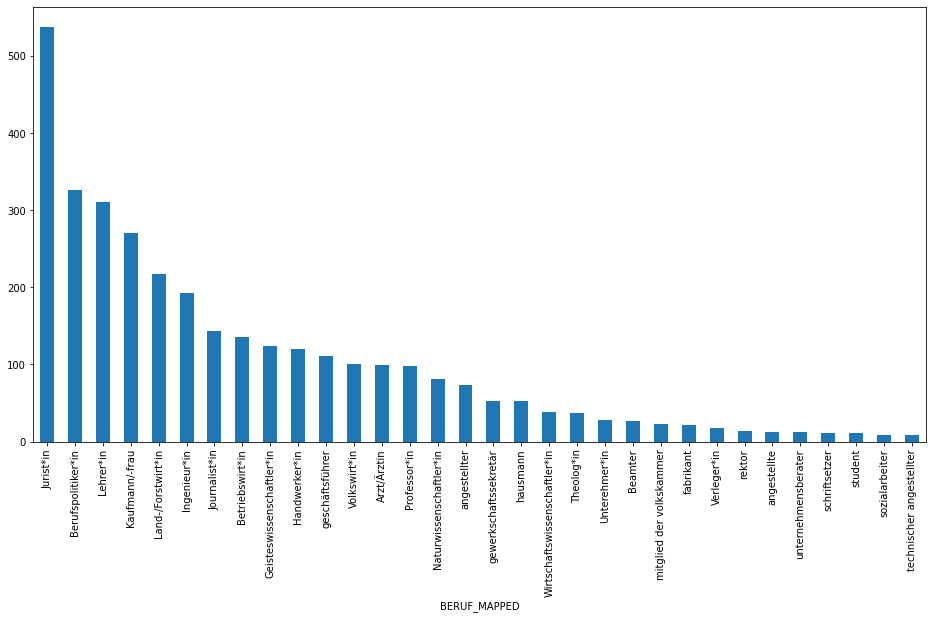

In [62]:
plt.figure(figsize=(16,8))
df_mdb.groupby('BERUF_MAPPED')['ID'].count().sort_values(ascending=False)[:32].plot(kind='bar')

In [63]:
len(set(df_mdb['BERUF_MAPPED']))

588

# construct df_mdb_wp

In [64]:
df_mdb_wp = get_mdb_wp_data(df_mdb)
print(df_mdb_wp.shape)

(11627, 19)


In [65]:
df_mdb_wp[df_mdb_wp.NACHNAME == 'Merkel'].head()

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,BERUF,PARTEI_KURZ,VITA_KURZ,VEROEFFENTLICHUNGSPFLICHTIGES,ANZ_WAHLPERIODEN,RELIGION_MAPPED,FAMILIENSTAND_MAPPED,BERUF_MAPPED,WP
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,evangelisch,verh.,Berufspolitiker*in,12
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,evangelisch,verh.,Berufspolitiker*in,13
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,evangelisch,verh.,Berufspolitiker*in,14
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,evangelisch,verh.,Berufspolitiker*in,15
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,evangelisch,verh.,Berufspolitiker*in,16


# save as csv

In [66]:
df_mdb.to_csv(DF_MDB_PATH, index=None)
df_mdb_wp.to_csv(DF_MDB_WP_PATH, index=None)

# read in data. exploratory data analysis

In [67]:
df_mdb = pd.read_csv(DF_MDB_PATH, index_col=None)
df_mdb_wp = pd.read_csv(DF_MDB_WP_PATH, index_col=None)

In [68]:
df_mdb.columns

Index(['ID', 'NACHNAME', 'VORNAME', 'GEBURTSDATUM', 'GEBURTSORT',
       'GEBURTSLAND', 'STERBEDATUM', 'GESCHLECHT', 'FAMILIENSTAND', 'RELIGION',
       'BERUF', 'PARTEI_KURZ', 'VITA_KURZ', 'VEROEFFENTLICHUNGSPFLICHTIGES',
       'ANZ_WAHLPERIODEN', '5', '6', '7', '8', '9', '10', '11', '3', '4', '2',
       '12', '13', '14', '15', '16', '1', '17', '18', '19', 'RELIGION_MAPPED',
       'FAMILIENSTAND_MAPPED', 'BERUF_MAPPED'],
      dtype='object')

In [69]:
df_mdb.tail()

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,...,14,15,16,1,17,18,19,RELIGION_MAPPED,FAMILIENSTAND_MAPPED,BERUF_MAPPED
4084,11004958,Nölke,Matthias,08.01.1980,Kassel,UNBEKANNT,UNBEKANNT,männlich,ledig,konfessionslos,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,konfessionslos,ledig,Jurist*in
4085,11004959,Martin,Dorothee,21.01.1978,UNBEKANNT,UNBEKANNT,UNBEKANNT,weiblich,UNBEKANNT,UNBEKANNT,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,UNBEKANNT,UNBEKANNT,selbstständige kommunikationsberater
4086,11004960,Wetzel,Wolfgang,11.05.1968,Schlema,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 2 Kinder",römisch-katholisch,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,katholisch,"verh., 2 Kinder",Lehrer*in
4087,11004961,Natterer,Christian,19.02.1981,Tettnang / Deutschland,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 1 Kind",römisch-katholisch,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,katholisch,"verh., 1 Kind",Kaufmann/-frau
4088,11004962,Dahmen,Janosch,06.09.1981,UNBEKANNT,UNBEKANNT,UNBEKANNT,männlich,UNBEKANNT,UNBEKANNT,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,UNBEKANNT,UNBEKANNT,Arzt/Ärztin


In [70]:
df_mdb_wp[['ID', 'WP']].groupby('WP').count().sort_values(by='WP', ascending=False).head()

,ID
WP,
19,738
18,658
17,652
16,642
15,628


# quality checks

In [ ]:
df_mdb_wp[(df_mdb_wp.WP==19) & (df_mdb_wp.PARTEI_KURZ == 'CDU')]

In [ ]:
df_mdb_wp[(df_mdb_wp.WP==18) & (df_mdb_wp.PARTEI_KURZ == 'CDU') & (df_mdb_wp.BERUF.str.contains('Bürgermeister'))]